In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline



In [3]:
train_data = pd.read_csv("train.csv")

print(train_data.head())
print(train_data.info())
print(train_data['target'].value_counts())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
target
0    4342
1    3271
Name: cou

In [5]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [10]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[^A-Za-z]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

train_data['processed_text'] = train_data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [11]:
print(train_data['processed_text'].head())

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: processed_text, dtype: object


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_data['processed_text'], train_data['target'], test_size=0.2, random_state=42
)


In [13]:
model_baseline = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_baseline.fit(X_train, y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

Accuracy: 0.7899


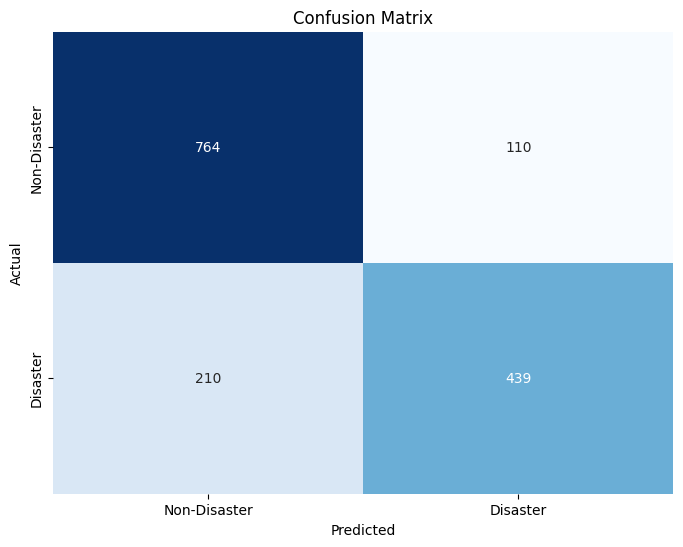

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.83       874
           1       0.80      0.68      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [14]:
predictions_baseline = model_baseline.predict(X_valid)

accuracy_baseline = accuracy_score(y_valid, predictions_baseline)
print(f'Accuracy: {accuracy_baseline:.4f}')

conf_matrix_baseline = confusion_matrix(y_valid, predictions_baseline)
class_report_baseline = classification_report(y_valid, predictions_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", class_report_baseline)


In [15]:
from sklearn.feature_selection import SelectKBest, chi2

model_improved = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    SelectKBest(chi2, k=10000),
    LogisticRegression(C=0.5)
)
model_improved.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('selectkbest',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x000001B470350220>)),
                ('logisticregression', LogisticRegression(C=0.5))])

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'selectkbest__k': [10000, 20000],
    'logisticregression__C': [0.5, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model_improved, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\USER\AppData\Loc

Best parameters: {'logisticregression__C': 1.0, 'selectkbest__k': 10000, 'tfidfvectorizer__ngram_range': (1, 1)}
Best score: 0.8014778325123153


Accuracy: 0.7853


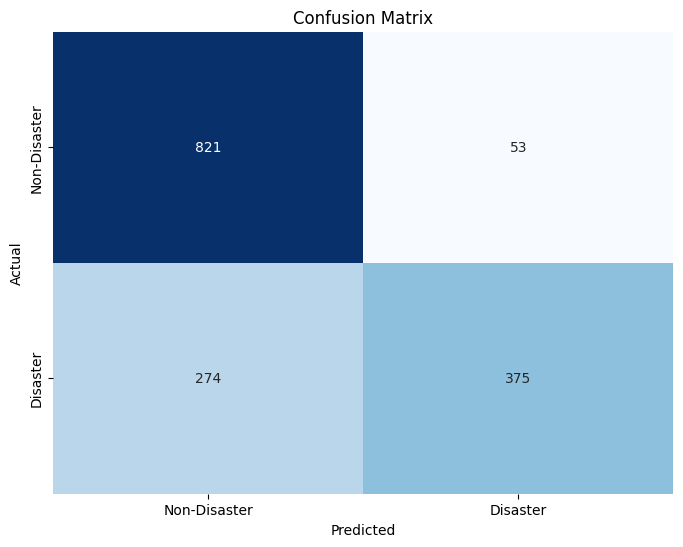

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83       874
           1       0.88      0.58      0.70       649

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523



In [17]:
predictions_improved = model_improved.predict(X_valid)

accuracy_improved = accuracy_score(y_valid, predictions_improved)
print(f'Accuracy: {accuracy_improved:.4f}')

conf_matrix_improved = confusion_matrix(y_valid, predictions_improved)
class_report_improved = classification_report(y_valid, predictions_improved)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_improved, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", class_report_improved)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=50)
X_valid_seq = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen=50)

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=50))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_seq, y_train, epochs=5, validation_data=(X_valid_seq, y_valid))





Epoch 1/5


191/191 [==============================] - 35s 136ms/step - loss: 0.5324 - accuracy: 0.7309 - val_loss: 0.4478 - val_accuracy: 0.7938
Epoch 2/5
191/191 [==============================] - 24s 126ms/step - loss: 0.3352 - accuracy: 0.8631 - val_loss: 0.4657 - val_accuracy: 0.7873
Epoch 3/5
191/191 [==============================] - 24s 125ms/step - loss: 0.2524 - accuracy: 0.8980 - val_loss: 0.5178 - val_accuracy: 0.7584
Epoch 4/5
191/191 [==============================] - 25s 131ms/step - loss: 0.1876 - accuracy: 0.9268 - val_loss: 0.6328 - val_accuracy: 0.7702
Epoch 5/5
191/191 [==============================] - 24s 124ms/step - loss: 0.1408 - accuracy: 0.9493 - val_loss: 0.7565 - val_accuracy: 0.7479


In [29]:
import pandas as pd

# Load the test data
test_data = pd.read_csv("test.csv")

# Preprocess the test data
test_data_seq = tokenizer.texts_to_sequences(test_data['text'])
test_data_seq = pad_sequences(test_data_seq, maxlen=50)

# Make predictions
predictions = model_lstm.predict(test_data_seq)

# Convert probabilities to class labels
predictions = (predictions > 0.5).astype(int)

# Flatten the predictions array
predictions = predictions.flatten()

# Create a DataFrame
df = pd.DataFrame({'id': test_data['id'], 'target': predictions})

# Save to CSV
df.to_csv('predictions.csv', index=False)

102/102 [==============================] - 3s 30ms/step


In [32]:
model_lstm.save('model_lstm.h5')
model_lstm.save('my_nlp_disastertweets_model.keras')

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
